In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from quspin.basis import spin_basis_1d
from quspin.operators import hamiltonian
from quspin.tools.evolution import ED_state_vs_time, expm_multiply_parallel
from quspin.tools.Floquet import Floquet_t_vec, Floquet
from tqdm import tqdm

plt.rcParams.update({
    "text.usetex": True,
})
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.fallback'] = 'stix'
plt.rcParams['font.family'] ='Times New Roman'
plt.style.use('seaborn-v0_8-deep')
prop_cycle = plt.rcParams['axes.prop_cycle']
dcolors = prop_cycle.by_key()['color']

# Model

The O'brian-Fendley model is much like the normal Majorana-Hubbard chain but with a slightly modified interaction term:

\begin{align*}
H_{OF} =& -it\sum_j \gamma_j \gamma_{j+1} -g \sum_j \gamma_{j-2}\gamma_{j-1}\gamma_{j+1}\gamma_{j+2}\\
=& t \sum_j \left(\sigma_j^x +\sigma_j^z \sigma_{j+1}^z\right)
+g \sum_j\left(\sigma_j^x \sigma_{j+1}^x \sigma_{j+2}^z + \sigma_j^z \sigma_{j+1}^z \sigma_{j+2}^z\right)
\end{align*}

In [6]:
def drive(t, omega):
    return np.cos(omega*t)

def Hof_dynamic(omega, g, basis):
    """
    Hopping strength is cos(omega t) (time t is fed later to the Hamiltonian function)
    g is the coupling strength
    basis is quspin spinless_fermion_basis_1d
    """
    
    L = basis.N
    
    x_lst = [[-2, i] for i in range(L)]
    
    zz_lst = [[-2, i, i+1] for i in range(L-1)]
    
    xzz_lst = [[g, i, i+1, i+2] for i in range(L-2)]
    zzx_lst = [[g, i, i+1, i+2] for i in range(L-2)]

    zz_lst += [[-2, L-1, 0]]
    
    xzz_lst += [[g, L-2, L-1, 0],
                [g, L-1, 0, 1]]
    
    zzx_lst += [[g, L-2, L-1, 0],
                [g, L-1, 0, 1]]
    static = [['xzz', xzz_lst],
              ['zzx', zzx_lst]]
    dynamic = [['x', x_lst, drive, [omega]],
               ['zz', zz_lst, drive, [omega]]]
    
    H = hamiltonian(static, dynamic, basis=basis, check_symm=False, check_herm=False)
    return H

In [7]:
L = 4
basis = spin_basis_1d(L, pauli=1) # pauli matrix, not spin 1/2 (matches iTensor "S=1/2")
g = 1
omega = 1
H = Hof_dynamic(omega, g, basis)
e, v = H.eigh(time=0) # diagonalizing at time t=0
print(e[:10]) # +L*(t**2+g**2)/g)
v0 = v[:,0]

[-8.00000000e+00 -8.00000000e+00 -8.00000000e+00 -4.94427191e+00
 -4.00000000e+00 -4.00000000e+00 -3.71247968e-15 -1.22826041e-15
 -7.61435507e-16  2.32554539e-16]


# Time evolution

I'm going to start with the $t=0$ ground state and evolve for a few periods using a built-in function from QuSpin that handles dynamic Hamiltonians by solving the Schrodinger equation. I don't know how efficient it is, so beware for large systems! This will take a while even for $L=8$.

In [8]:
steps = 301
tf = 6*np.pi # 3 periods, 100 steps per period
times = np.linspace(0, tf, steps)
energies = np.zeros(steps)
olaps = np.zeros(steps, dtype=np.complex128)
vs = H.evolve(v0, 0, times, iterate=True)
for i, vi in tqdm(enumerate(vs), total=steps): # tqdm just makes a progress bar. Feel free to replace this line with enumerate(vs):
    t = times[i]
    #print(f"t/2 pi = {np.round(t/(2*np.pi), 3)}")
    energies[i] = H.expt_value(vi, time=t).real
    olaps[i] = np.vdot(vi, v0)
    #print(f"e = {energies[i]}, |overlap| = {np.abs(olaps[i])}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 2074.31it/s]


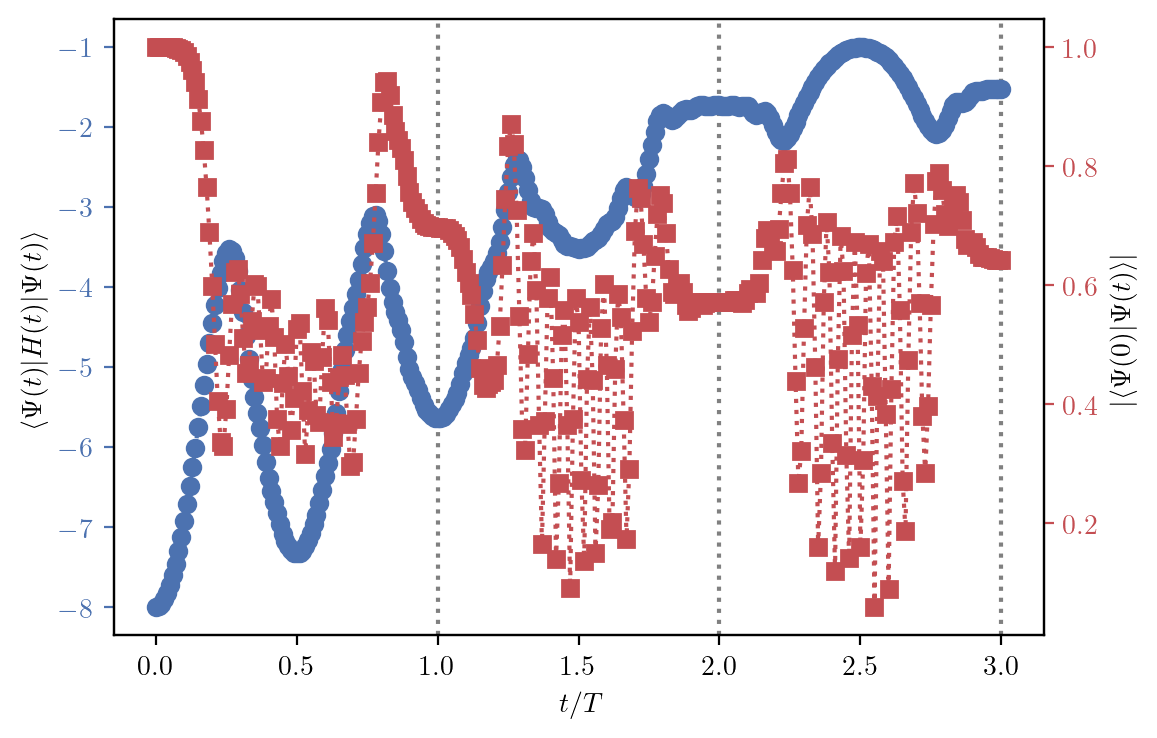

In [9]:
fig, ax = plt.subplots(figsize=(6,4), dpi=200)
ax.plot(times/(2*np.pi), energies, 'o:')
ax.axvline(1, color="gray", ls=':', zorder=-1)
ax.axvline(2, color="gray", ls=':', zorder=-1)
ax.axvline(3, color="gray", ls=':', zorder=-1)

ax.set_xlabel(r'$t/T$')
ax.set_ylabel(r'$\langle\Psi(t)|H(t)|\Psi(t)\rangle$')# , color=dcolors[0])
ax.tick_params(axis='y', colors=dcolors[0])

ax2 = ax.twinx()
ax2.plot(times/(2*np.pi), np.abs(olaps), 's:', color=dcolors[2])
ax2.set_ylabel(r'$|\langle \Psi(0)|\Psi(t)\rangle|$') #, color=dcolors[2])
ax2.tick_params(axis='y', colors=dcolors[2])

### Comments

This plot shows energy in blue and overlap with the initial state in red.

It's interesting that the overlap seems to plateau at each period.

# Floquet spectrum, etc.

QuSpin provides code to comput the Floquet unitary $\mathcal U_F = \mathcal T_t \exp \left(-i\int_0^T d t H(t)\right)$ where $\mathcal T_t \exp$ is the time-ordered exponential.
I'm going to investigate what it's doing here.

In [14]:
L = 4
basis = spin_basis_1d(L, pauli=1)
g = 1
omega = 1
H = Hof_dynamic(omega, g, basis)

I'm kind of blindly copying the example from the docs here. This should compute the Floquet quasi-energies ```EF```, Hamiltonian ```HF```, evolution operator ```UF```, and eigenvasis ```VF```.

In [45]:
n_periods = 1
omega = 1
t = Floquet_t_vec(omega, n_periods, len_T=10)

t_list = t.T *np.arange(0, 1, 1/100) + np.finfo(float).eps # times to evaluate H

dt_list = np.array([t.T/100 for ti in t_list]) # time step durations to apply H for

Floq = Floquet(
    {"H": H, "t_list": t_list, "dt_list": dt_list}, HF=True, VF=True, UF=True
)  # call Floquet class

EF = np.sort(Floq.EF)
HF = Floq.HF
UF = Floq.UF
VF = Floq.VF

In [48]:
print(EF)

[-2.57395873e-01 -2.57395873e-01 -1.85532356e-16 -5.30092447e-17
 -3.39590474e-17 -2.42959038e-17 -1.25620866e-17 -4.41743706e-18
  5.10766160e-18  6.18441188e-17  5.85791720e-02  2.30170888e-01
  2.57395873e-01  2.57395873e-01  2.84566578e-01  4.26683361e-01]


According to the docs, it's also possible to do a continuous-time version of this via solving some ODEs up to relative tolerance ```rtol```. It seems to be quite slow, so beware!

In [50]:
Floq_c = Floquet({"H": H, 
                "T": 2*np.pi,
                "rtol": 1e-9})

In [51]:
EF_c = np.sort(Floq_c.EF)
print(EF_c)

[-2.57804984e-01 -2.57804984e-01 -3.69960354e-17 -1.76697482e-17
  1.25672915e-17  4.20001633e-17  6.18441188e-17  6.37960253e-17
  9.11719213e-17  1.01601052e-16  5.82376387e-02  2.30142425e-01
  2.57804983e-01  2.57804984e-01  2.84908112e-01  4.26711824e-01]


These are decently close! The errors are $\mathcal O(10^{-4})$ which is something like $(\delta t)^2$ for timestep $\delta t$ in the discretized case.